In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from helpers import *
from evaluation import *


In [ ]:
!pip install tensorflow-addons
!pip install pydot
!pip install tensorflow-io

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental import preprocessing
import pprint
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import rasterio.io
import sys
import traceback
import rasterio.features
import rasterio.warp
from rasterio.plot import show
import csv
import warnings
from statistics import mean
from datetime import datetime, date, time, timezone

#import helpers as helpers
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)
from packaging.version import parse as parse_version


print("Python version: " + sys.version)

Tensorflow 2.7.0
Python version: 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


In [39]:
DATASET_ROOT_PATH = '../../data/HiltonOfFern_crop_field_training_cloud_free_available_area'
HALF_MAX_RGB_INTENSITY = 905.8

if os.path.exists('datasets/filtered_ds'):
    tf.print("started loading filtered ds")
    list_ds = tf.data.experimental.load('datasets/filtered_ds')
    tf.print("finished loading filtered ds")
else:
    list_ds = tf.data.Dataset.list_files(DATASET_ROOT_PATH + '/*/*/S2/Patches/*.tif', shuffle=True, seed=42)



    # Reducing amount of data whilst getting stuff working. remember to comment out/delete this when finished!!!!!!!!!!!!!!
    #list_ds = list_ds.skip(4500)

    total_products = tf.data.experimental.cardinality(list_ds).numpy()
    print("total products = " + str(total_products))
    list_ds = list_ds.filter(filter_low_quality_data)
    # unfortunately filtering sets the cardinality for the dataset to -2 (unkown) so have to manually set it or will cause an error
    # when try to iterate through dataset during training
    list_ds = list_ds.apply(tf.data.experimental.assert_cardinality(len(list(list_ds))))
    total_products = tf.data.experimental.cardinality(list_ds).numpy()
    print("total products after filtering cloudy images = " + str(total_products))

    tf.data.experimental.save(list_ds, 'datasets/filtered_ds')

total_products = tf.data.experimental.cardinality(list_ds).numpy()
print("total products after filtering cloudy images = " + str(total_products))
train_size = int(total_products * 0.85)    
test_size = int(total_products * 0.07)
val_size = int(total_products * 0.07)
ver_size = int(total_products * 0.01)
print("test size = " + str(test_size))
train_ds = list_ds.take(train_size)
val_ds = list_ds.skip(train_size).take(val_size)
print("validation data has size " + str(tf.data.experimental.cardinality(val_ds).numpy()) + " and orig list is now " + str(tf.data.experimental.cardinality(list_ds).numpy()))
test_ds = list_ds.skip(train_size).skip(val_size).take(test_size)
ver_ds = list_ds.skip(train_size).skip(val_size).skip(test_size)

print("have split into train and test")
print("train has size " + str(tf.data.experimental.cardinality(train_ds).numpy()) + " whilst test has size " + str(tf.data.experimental.cardinality(test_ds).numpy()))
print("ver has size " + str(tf.data.experimental.cardinality(ver_ds).numpy()))

test_ds = test_ds.apply(tf.data.experimental.assert_cardinality(len(list(test_ds))))
print("recounted and test has size " + str(tf.data.experimental.cardinality(test_ds).numpy()))

#train_ds = train_ds.map(process_path)
train_ds_ratio = train_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, True ), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_ratio.apply(tf.data.experimental.ignore_errors())


train_ds_no_ratio = train_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, False ), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_no_ratio.apply(tf.data.experimental.ignore_errors())

# rescale sentinel 2 rgb values to between -1 and 1 (as we use tan for generator output)
rescaling_layer = Rescaling(scale = 1./HALF_MAX_RGB_INTENSITY, offset=-1.)

train_ds_no_ratio = train_ds_no_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))
train_ds_ratio = train_ds_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))
tf.data.experimental.save(train_ds_ratio, 'datasets/train_ds_ratio')
tf.data.experimental.save(train_ds_no_ratio, 'datasets/train_ds_no_ratio')     
ratio_normalizer = preprocessing.Normalization()
# get just sen1 data to adapt my normalization layer
ratio_feature_ds = train_ds_ratio.map(lambda x, y, name: x)
ratio_normalizer.adapt(ratio_feature_ds)

norm_train_ds_ratio = train_ds_ratio.map(lambda x, y, name: (ratio_normalizer(x), y, name))
tf.data.experimental.save(norm_train_ds_ratio, 'datasets/norm_train_ds_ratio')     

no_ratio_normalizer = preprocessing.Normalization()
no_ratio_feature_ds = train_ds_no_ratio.map(lambda x, y, name: x)
no_ratio_normalizer.adapt(no_ratio_feature_ds)
norm_train_ds_no_ratio = train_ds_no_ratio.map(lambda x, y, name: (no_ratio_normalizer(x), y, name))
tf.data.experimental.save(norm_train_ds_no_ratio, 'datasets/norm_train_ds_no_ratio')     
print("finished preparing training data")




#test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_ratio = test_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, True ), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_ratio.apply(tf.data.experimental.ignore_errors())

test_ds_no_ratio = test_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, False ), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_no_ratio.apply(tf.data.experimental.ignore_errors())


# rescale sentinel 2 rgb values to between -1 and 1 (consistentg with test data which is set to -1 and 1 due to generator outputing tan)
test_ds_no_ratio = test_ds_no_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))
test_ds_ratio = test_ds_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))

tf.data.experimental.save(test_ds_no_ratio, 'datasets/test_ds_no_ratio')     
tf.data.experimental.save(test_ds_ratio, 'datasets/test_ds_ratio')     

# normalize sen 1 data 
norm_test_ds_ratio = test_ds_ratio.map(lambda x, y, name: (ratio_normalizer(x), y, name))
norm_test_ds_no_ratio = test_ds_no_ratio.map(lambda x, y, name: (no_ratio_normalizer(x), y, name))
tf.data.experimental.save(norm_test_ds_ratio, 'datasets/norm_test_ds_ratio')     
tf.data.experimental.save(norm_test_ds_no_ratio, 'datasets/norm_test_ds_no_ratio')     
# process validation data
val_ds_ratio = val_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, True ), num_parallel_calls=tf.data.AUTOTUNE)
val_ds_ratio.apply(tf.data.experimental.ignore_errors())

val_ds_no_ratio = val_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, False ), num_parallel_calls=tf.data.AUTOTUNE)
val_ds_no_ratio.apply(tf.data.experimental.ignore_errors())


# rescale sentinel 2 rgb values to between -1 and 1 (consistentg with test data which is set to -1 and 1 due to generator outputing tan)
val_ds_no_ratio = val_ds_no_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))
val_ds_ratio = val_ds_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))

tf.data.experimental.save(val_ds_no_ratio, 'datasets/val_ds_no_ratio')     
tf.data.experimental.save(val_ds_ratio, 'datasets/val_ds_ratio')     
# normalize sen 1 data 
norm_val_ds_ratio = val_ds_ratio.map(lambda x, y, name: (ratio_normalizer(x), y, name))
norm_val_ds_no_ratio = val_ds_no_ratio.map(lambda x, y, name: (no_ratio_normalizer(x), y, name))

tf.data.experimental.save(val_ds_ratio, 'datasets/norm_val_ds_ratio')     
tf.data.experimental.save(val_ds_ratio, 'datasets/norm_val_ds_no_ratio')     
# process verification data

ver_ds_ratio = ver_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, True ), num_parallel_calls=tf.data.AUTOTUNE)
ver_ds_ratio.apply(tf.data.experimental.ignore_errors())

ver_ds_no_ratio = ver_ds.map(lambda x: process_path(x, CLIP_VALUE, "clip", 0, False ), num_parallel_calls=tf.data.AUTOTUNE)
ver_ds_no_ratio.apply(tf.data.experimental.ignore_errors())

# rescale sentinel 2 rgb values to between -1 and 1 (consistentg with test data which is set to -1 and 1 due to generator outputing tan)
ver_ds_no_ratio = ver_ds_no_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))
ver_ds_ratio = ver_ds_ratio.map(lambda x, y, name: (x, rescaling_layer(y), name))

tf.data.experimental.save(ver_ds_no_ratio, 'datasets/ver_ds_no_ratio')     
tf.data.experimental.save(ver_ds_no_ratio, 'datasets/ver_ds_no_ratio')     

# normalize sen 1 data 
norm_ver_ds_ratio = ver_ds_ratio.map(lambda x, y, name: (ratio_normalizer(x), y, name))
norm_ver_ds_no_ratio = ver_ds_no_ratio.map(lambda x, y, name: (no_ratio_normalizer(x), y, name))

tf.data.experimental.save(norm_ver_ds_ratio, 'datasets/norm_ver_ds_ratio')     
tf.data.experimental.save(norm_ver_ds_no_ratio, 'datasets/norm_ver_ds_no_ratio')     



print("finished preparing data")

started loading filtered ds
finished loading filtered ds
total products after filtering cloudy images = 769
test size = 53
validation data has size 53 and orig list is now 769
have split into train and test
train has size 653 whilst test has size 53
ver has size 10
recounted and test has size 53
finished preparing training data
finished preparing data


In [8]:
input_image_shape = (256, 256, 2)
output_image_shape = (256, 256, 3)
class MyPIX2PIX():
    #def __init__(self, input_shape):
    def __init__(self):
        #self.input_shape = input_shape

        # discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = False
        self.optimizer_discriminator = Adam(2e-4, 0.5, 0.9999)
                
        # build generator pipeline with frozen discriminator
        self.generator = self.build_generator()
        discriminator_output = self.discriminator([self.generator.input, 
                                                   self.generator.output])
        self.patch_size = discriminator_output.shape[1]
        self.model = Model(self.generator.input, [discriminator_output, self.generator.output])
        self.LAMBDA = 100
        self.model.compile(loss = ['bce','mae'],
                           optimizer = Adam(2e-4, 0.5, 0.9999),
                           loss_weights=[1, self.LAMBDA])
        self.discriminator.trainable = True
        self.bce = tf.keras.losses.BinaryCrossentropy()
        
    def bce_loss(self, y_true, y_pred):
        
        loss = self.bce(y_true, y_pred)

        return loss
    
    def downsample(self, channels, kernels, strides=2, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def upsample(self, channels, kernels, strides=1, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.UpSampling2D((2,2)))
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def build_generator(self):

        DIM = 64

        input_image = layers.Input(shape=input_image_shape)
        down1 = self.downsample(DIM, 4, norm=False)(input_image) # 128, DIM
        down2 = self.downsample(2*DIM, 4)(down1) # 64, 2*DIM
        down3 = self.downsample(4*DIM, 4)(down2) # 32, 4*DIM
        down4 = self.downsample(4*DIM, 4)(down3) # 16, 4*DIM
        down5 = self.downsample(4*DIM, 4)(down4) # 8, 4*DIM
        down6 = self.downsample(4*DIM, 4)(down5) # 4, 4*DIM
        down7 = self.downsample(4*DIM, 4)(down6) # 2, 4*DIM


        up6 = self.upsample(4*DIM, 4, dropout=True)(down7) # 4,4*DIM
        concat6 = layers.Concatenate()([up6, down6])   

        up5 = self.upsample(4*DIM, 4, dropout=True)(concat6) 
        concat5 = layers.Concatenate()([up5, down5]) 

        up4 = self.upsample(4*DIM, 4, dropout=True)(concat5) 
        concat4 = layers.Concatenate()([up4, down4]) 

        up3 = self.upsample(4*DIM, 4)(concat4) 
        concat3 = layers.Concatenate()([up3, down3]) 

        up2 = self.upsample(2*DIM, 4)(concat3) 
        concat2 = layers.Concatenate()([up2, down2]) 

        up1 = self.upsample(DIM, 4)(concat2) 
        concat1 = layers.Concatenate()([up1, down1]) 

        output_image = tanh(self.upsample(3, 4, norm=False, activation=False)(concat1))

        return Model(input_image, output_image, name='generator')         
    
    def build_discriminator(self):
        DIM = 64
        # model = tf.keras.Sequential(name='discriminators')   REDUNDANT?
        input_image_A = layers.Input(shape=input_image_shape)
        input_image_B = layers.Input(shape=output_image_shape)
        
        x = layers.Concatenate()([input_image_A, input_image_B])
        x = self.downsample(DIM, 4, norm=False)(x) # 128
        x = self.downsample(2*DIM, 4)(x) # 64
        x = self.downsample(4*DIM, 4)(x) # 32
        x = self.downsample(8*DIM, 4, strides=1)(x) # 29
        output = layers.Conv2D(1, 4, activation='sigmoid')(x)

        return Model([input_image_A, input_image_B], output)     
    
    def train_discriminator(self, real_images_A, real_images_B, batch_size):
        
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))
         
        fake_images_B = self.generator.predict(real_images_A)
             
        with tf.GradientTape() as gradient_tape:
            
            # forward pass
            pred_fake = self.discriminator([real_images_A, fake_images_B])
            tf.print("pred fake ", tf.shape(pred_fake))
            pred_real = self.discriminator([real_images_A, real_images_B])
            
            # calculate losses
            tf.print(tf.shape(fake_labels))
            loss_fake = self.bce_loss(fake_labels, pred_fake)
            loss_real = self.bce_loss(real_labels, pred_real)           
            
            # total loss
            total_loss = 0.5*(loss_fake + loss_real)
            
            # apply gradients
            gradients = gradient_tape.gradient(total_loss, self.discriminator.trainable_variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return loss_fake, loss_real
    
    def train(self, train_data_generator, test_data_generator, batch_size, steps, interval=100):
        val_images = next(test_data_generator) 
        #print("val_images values below\n")
        tf.print(val_images[0].shape)
        tf.print(val_images[1].shape)
    
        
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))

        self.batch_size = batch_size
        for i in range(steps):
    
            real_s1, real_s2 = next(train_data_generator)
            loss_fake, loss_real = self.train_discriminator(real_s1, real_s2, batch_size)
            discriminator_loss = 0.5*(loss_fake + loss_real)
                
            # train generator
            g_loss = self.model.train_on_batch(real_s1, [real_labels, real_s2])
            if i%interval == 0:
                msg = "Step {}: discriminator_loss {:.4f} g_loss {:.4f}"\
                .format(i, discriminator_loss, g_loss[0])
                print(msg)
                
                fake_images = self.generator.predict(val_images[0])
                #print("fake images shape = " + str(fake_images.shape) + " pprint below \n")
                #pp.pprint(fake_images)
                
                self.plot_images(val_images[1], fake_images)
            
    def plot_images(self, real_images, fake_images):   
        grid_row = min(fake_images.shape[0], 4)
        print("grid_row = " + str(grid_row) + "\n")
        grid_col = 2
        
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*6, grid_row*6))
        for row in range(grid_row):
            ax = axarr if grid_row==1 else axarr[row]
            #ax[0].imshow((real_images[0][row]+1)/2)
            #ax[0].axis('off') 
            #ax[1].imshow((real_images[1][row]+1)/2)
            ax[0].imshow((real_images[row]+1)/2)
            ax[0].axis('off') 
            ax[1].imshow((fake_images[row]+1)/2)
            ax[1].axis('off') 
        plt.show()
        
    def sample_images(self, number):
        z = tf.random.normal((number, self.z_dim))
        images = self.generator.predict(z)
        self.plot_images(images)
        return images

pix2pix = PIX2PIX()

TypeError: __init__() missing 2 required positional arguments: 'input_shape' and 'settings'

In [40]:
image_shape = (256, 256, 3)
class PIX2PIX():
    def __init__(self, input_shape, settings, training_progress=None):
        self.input_shape = input_shape
        self.settings = settings
        if training_progress == None:
            # initialise training progress variables
            self.training_progress = {}
            self.training_progress["g_loss_hist"] = []
            self.training_progress["d_loss_hist"] = []
            self.training_progress["g_batch_loss"] = []
            self.training_progress["d_batch_loss"] = []
            self.training_progress["train_ms_ssimm_hist"] = []
            self.training_progress["val_ms_ssim_hist"] = []
            self.training_progress["epochs_without_improving"] = 0
            self.training_progress["epochs_trained"] = 0
            self.training_progress["cur_best_ms_ssim"] = 0
            self.training_progress["prev_val_ms_ssim"] = 0
            self.training_progress["prev_d_batch_loss"] = 0
            self.training_progress["cur_step"] = 0
            # create generator and discriminator
            
            self.discriminator = self.build_discriminator()
            self.discriminator.trainable = False
            

            self.generator = self.build_generator()
            
        else:
            self.training_progress = training_progress
            self.generator = tf.keras.models.load_model("saved_weights/best_g_so_far")
            self.discriminator = tf.keras.models.load_model("saved_weights/best_d_so_far")
        
        self.optimizer_discriminator = Adam(self.settings["d-lr"], 0.5, 0.9999)
        discriminator_output = self.discriminator([self.generator.input, 
                                                       self.generator.output])                                                    
        self.patch_size = discriminator_output.shape[1]
        self.model = Model(self.generator.input, [discriminator_output, self.generator.output])
        self.LAMBDA = 100
        self.model.compile(loss = ['bce','mae'],
                           optimizer = Adam(self.settings["g-lr"], 0.5, 0.9999),
                           loss_weights=[1, self.LAMBDA])
        self.discriminator.trainable = True
        self.bce = tf.keras.losses.BinaryCrossentropy()
        
    def bce_loss(self, y_true, y_pred):
        
        loss = self.bce(y_true, y_pred)

        return loss
    
    def downsample(self, channels, kernels, strides=2, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def upsample(self, channels, kernels, strides=1, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.UpSampling2D((2,2)))
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def build_generator(self):

        DIM = 64

        input_image = layers.Input(shape=image_shape)
        down1 = self.downsample(DIM, 4, norm=False)(input_image) # 128, DIM
        down2 = self.downsample(2*DIM, 4)(down1) # 64, 2*DIM
        down3 = self.downsample(4*DIM, 4)(down2) # 32, 4*DIM
        down4 = self.downsample(4*DIM, 4)(down3) # 16, 4*DIM
        down5 = self.downsample(4*DIM, 4)(down4) # 8, 4*DIM
        down6 = self.downsample(4*DIM, 4)(down5) # 4, 4*DIM
        down7 = self.downsample(4*DIM, 4)(down6) # 2, 4*DIM


        up6 = self.upsample(4*DIM, 4, dropout=True)(down7) # 4,4*DIM
        concat6 = layers.Concatenate()([up6, down6])   

        up5 = self.upsample(4*DIM, 4, dropout=True)(concat6) 
        concat5 = layers.Concatenate()([up5, down5]) 

        up4 = self.upsample(4*DIM, 4, dropout=True)(concat5) 
        concat4 = layers.Concatenate()([up4, down4]) 

        up3 = self.upsample(4*DIM, 4)(concat4) 
        concat3 = layers.Concatenate()([up3, down3]) 

        up2 = self.upsample(2*DIM, 4)(concat3) 
        concat2 = layers.Concatenate()([up2, down2]) 

        up1 = self.upsample(DIM, 4)(concat2) 
        concat1 = layers.Concatenate()([up1, down1]) 

        output_image = tanh(self.upsample(3, 4, norm=False, activation=False)(concat1))

        return Model(input_image, output_image, name='generator')         
    
    def build_discriminator(self):
        DIM = 64
        model = tf.keras.Sequential(name='discriminators') 
        input_image_A = layers.Input(shape=image_shape)
        input_image_B = layers.Input(shape=image_shape)
        
        x = layers.Concatenate()([input_image_A, input_image_B])
        x = self.downsample(DIM, 4, norm=False)(x) # 128
        x = self.downsample(2*DIM, 4)(x) # 64
        x = self.downsample(4*DIM, 4)(x) # 32
        x = self.downsample(8*DIM, 4, strides=1)(x) # 29
        output = layers.Conv2D(1, 4, activation='sigmoid')(x)

        return Model([input_image_A, input_image_B], output)     
    
    def train_discriminator(self, real_images_A, real_images_B):
        batch_size = real_images_A.shape[0] # better calculating this on the fly as last batch might have less images if the size of the dataset isn't divisible by the batch size!
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))
                  
        fake_images_B = self.generator.predict(real_images_A)
        
        with tf.GradientTape() as gradient_tape:
            
            # forward pass
            pred_fake = self.discriminator([real_images_A, fake_images_B])
            pred_real = self.discriminator([real_images_A, real_images_B])
            
            # calculate losses
            loss_fake = self.bce_loss(fake_labels, pred_fake)
            loss_real = self.bce_loss(real_labels, pred_real)           
            
            # total loss
            total_loss = 0.5*(loss_fake + loss_real)
            
            # apply gradients
            gradients = gradient_tape.gradient(total_loss, self.discriminator.trainable_variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return loss_fake, loss_real
    
    def train(self, train_data_generator, val_data_generator, batch_size, max_epochs, steps_per_epoch=100):
        val_sen1, val_sen2, val_filenames = next(val_data_generator)
        rescaled_val_sen2 = (val_sen2+1)/2   

        max_steps = max_epochs * steps_per_epoch
        
        self.batch_size = batch_size
        while self.training_progress["cur_step"] < max_steps:
    
            real_sen1, real_sen2, filename = next(train_data_generator)
            # set real labels, moved this inside loop as shape will change for the last batch if the dataset doesn't divide nicely by the batch size
            real_labels = tf.ones((real_sen1.shape[0], self.patch_size, self.patch_size, 1)) 
    
            loss_fake, loss_real = self.train_discriminator(real_sen1, real_sen2)
            discriminator_loss = 0.5*(loss_fake + loss_real)
            self.training_progress["d_batch_loss"].append(discriminator_loss.numpy())
            # train generator
            g_loss = self.model.train_on_batch(real_sen1, [real_labels, real_sen2])
            self.training_progress["g_batch_loss"].append(g_loss[0])
            if self.training_progress["cur_step"] %steps_per_epoch == 0 and self.training_progress["cur_step"] != 0:
                self.training_progress["epochs_trained"] += 1
                self.training_progress["g_loss_hist"].append(mean(self.training_progress["g_batch_loss"]))
                avg_d_batch_loss  = mean(self.training_progress["d_batch_loss"])
                self.training_progress["d_loss_hist"].append(avg_d_batch_loss)
                self.training_progress["g_batch_loss"] = []
                self.training_progress["d_batch_loss"] = []
                fake_val_images = self.generator.predict(val_sen1)
                fake_val_images = (fake_val_images+1)/2
                
                val_ms_ssim = tf.math.reduce_mean(tf.image.ssim_multiscale(rescaled_val_sen2, fake_val_images, max_val=1.0).numpy())
                self.training_progress["val_ms_ssim_hist"].append(val_ms_ssim)
                
                msg = "Step {}: discriminator_loss {:.4f} g_loss {:.4f} MS SSIM on valdidation images {:.4f}"\
                .format(self.training_progress["cur_step"], discriminator_loss, g_loss[0], val_ms_ssim)
                print(msg)
                
                self.plot_images(val_sen1[0], rescaled_val_sen2[0], fake_val_images[0]) 
                
                if val_ms_ssim < self.training_progress["prev_val_ms_ssim"] + self.settings["early-stopping-min-delta"] or (avg_d_batch_loss + self.settings["early-stopping-min-delta"] > self.training_progress["prev_d_batch_loss"] and self.training_progress["epochs_trained"] != 1):
                    self.training_progress["epochs_without_improving"] +=1
                    print("epochs without improving increased to " + str(self.training_progress["epochs_without_improving"]))
                else:
                    self.training_progress["epochs_without_improving"] = 0
                    print("epochs without improving reset to 0")
                    if val_ms_ssim > self.training_progress["cur_best_ms_ssim"]:
                        self.training_progress["cur_best_ms_ssim"] = val_ms_ssim
                        self.generator.save("saved_weights/best_g_so_far")
                        self.discriminator.save("saved_weights/best_d_so_far")
                if self.training_progress["epochs_without_improving"] >= self.settings["patience"]:
                    print("early stopping due to lack of improvement")
                    self.generator = tf.keras.models.load_model("saved_weights/best_g_so_far")
                    return self.training_progress["g_loss_hist"], self.training_progress["d_loss_hist"], self.training_progress["val_ms_ssim_hist"], self.training_progress["cur_step"], True
                
                self.training_progress["prev_val_ms_ssim"] = val_ms_ssim
                self.training_progress["prev_d_batch_loss"] = avg_d_batch_loss
            self.training_progress["cur_step"] +=1
            
           
            with open('training_progress.pkl','wb') as training_file:
                pickle.dump(self.training_progress, training_file)
            
        return self.training_progress["g_loss_hist"], self.training_progress["d_loss_hist"], self.training_progress["val_ms_ssim_hist"], self.training_progress["cur_step"], False
        
    def plot_images(self, real_sen1, real_sen2, fake_images):   
        grid_col = 3
        
        f, ax = plt.subplots(1, grid_col, figsize=(grid_col*6, 6))
        
        ax[0].imshow(real_sen1)
        ax[0].axis('off') 
        ax[1].imshow(real_sen2)
        ax[1].axis('off') 
        ax[2].imshow(fake_images)
        ax[2].axis('off') 
        plt.show()
        
    def sample_images(self, number):
        z = tf.random.normal((number, self.z_dim))
        images = self.generator.predict(z)
        self.plot_images(images)
        return images
    

In [ ]:
tf.keras.utils.plot_model(pix2pix.generator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(pix2pix.discriminator, show_shapes=True)

Step 65: discriminator_loss 0.5987 g_loss 18.5860 MS SSIM on valdidation images 0.2196


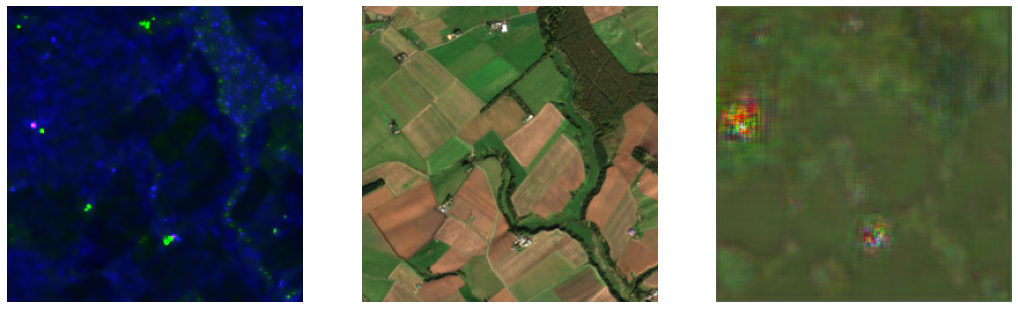

epochs without improving reset to 0


INFO:tensorflow:Assets written to: saved_weights/best_g_so_far/assets


INFO:tensorflow:Assets written to: saved_weights/best_g_so_far/assets


INFO:tensorflow:Assets written to: saved_weights/best_d_so_far/assets


INFO:tensorflow:Assets written to: saved_weights/best_d_so_far/assets


Step 130: discriminator_loss 0.3620 g_loss 20.3434 MS SSIM on valdidation images 0.2094


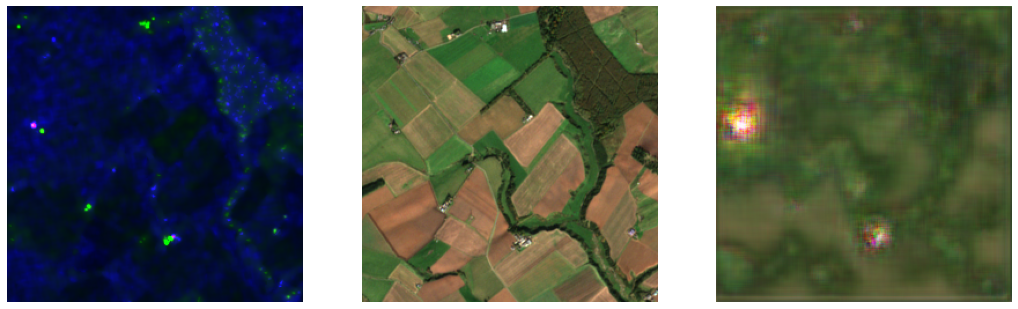

epochs without improving increased to 1


Step 195: discriminator_loss 0.3074 g_loss 18.6768 MS SSIM on valdidation images 0.2176


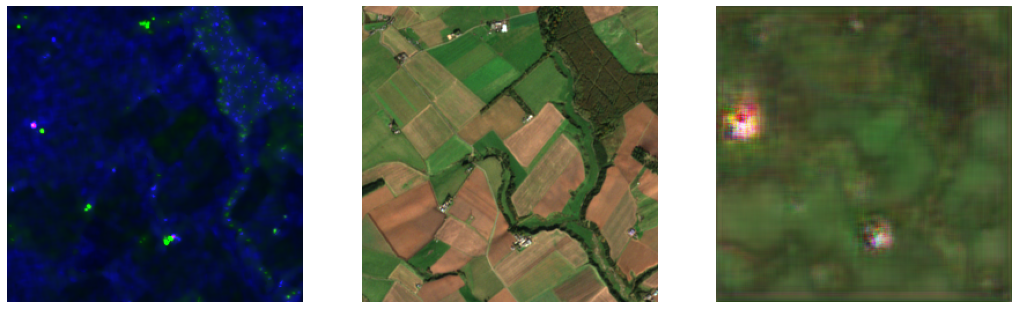

epochs without improving increased to 2


In [ ]:
BATCH_SIZE = 10

norm_train_ds_ratio = tf.data.experimental.load('datasets/norm_train_ds_ratio')
norm_test_ds_ratio = tf.data.experimental.load('datasets/norm_test_ds_ratio')
norm_val_ds_ratio = tf.data.experimental.load('datasets/norm_val_ds_ratio')
norm_ver_ds_ratio = tf.data.experimental.load('datasets/norm_ver_ds_ratio')

norm_test_ds_ratio_batched = norm_test_ds_ratio.batch(tf.data.experimental.cardinality(norm_test_ds_ratio).numpy())
norm_val_ds_ratio_batched = norm_val_ds_ratio.batch(tf.data.experimental.cardinality(norm_val_ds_ratio).numpy())
norm_train_ds_ratio_batched = norm_train_ds_ratio.batch(BATCH_SIZE).repeat()

steps_per_epoch = int(tf.data.experimental.cardinality(norm_train_ds_ratio).numpy() / BATCH_SIZE)

no_epochs = 250

restarting_training = False


try:
    with open('results.csv', 'a') as file:
        gan_settings = { "g-lr": 0.0001, "d-lr": 0.0001, "patience": 5, "early-stopping-min-delta": 0.01}
        experiment_name = "Baseline model"
        if restarting_training:
            with open('training_progress.pkl', 'rb') as pickle_file:
                training_progress = pickle.load(pickle_file)
            pix2pix = PIX2PIX((256, 256, 3), gan_settings, training_progress)
        else:
            pix2pix = PIX2PIX((256, 256, 3), gan_settings)
            
        g_loss, d_loss, val_ssim, steps_trained, stopped_early = pix2pix.train(iter(norm_train_ds_ratio_batched), iter(norm_val_ds_ratio_batched), BATCH_SIZE, no_epochs, steps_per_epoch)
        cur_date = datetime.now()
        
        file_name = str(cur_date.strftime("%Y-%m-%d %H:%M:%S")) + experiment_name + str(gan_settings)
        file_name = file_name.replace(" ", "_")
        file_name = file_name.replace("{", "_")
        file_name = file_name.replace(",", "")
        file_name = file_name.replace(":", "")
        file_name = file_name.replace("}", "")
        file_name = file_name.replace("'", "")
        file_name = file_name[0:246] # shorten filename so don't go over max linux filesilze
        
        

        plt.figure(0)
        plt.plot(val_ssim)
        plt.xlabel("Epochs")
        plt.ylabel("Average MS SSIM score on validation data")
        #plt.legend()
        plt.savefig("saved_training_plots/" + file_name + "ssim.jpg")
        plt.show()

        plt.figure(1)
        plt.plot(g_loss, label = "Generator loss")
        plt.plot(d_loss, label = "Discriminator loss")
        plt.xlabel("Epochs")
        plt.ylabel("Training Loss")
        plt.legend()
        
        

        plt.savefig("saved_training_plots/" + file_name + "loss.jpg")
        plt.show()
        pix2pix.generator.save("saved_weights/pix2pix_sentinelv1")

        img_metrics = eval_test_set(pix2pix, norm_test_ds_ratio, experiment_name)

        csv_fields = { "date": str(cur_date.strftime("%Y-%m-%d %H:%M:%S")),
                       "experiment name": experiment_name,
                       "steps trained": steps_trained,
                       "stopped early": stopped_early
                        }
        csv_fields.update(gan_settings)
        csv_fields.update(img_metrics)

        writer = csv.DictWriter(file, fieldnames=list(csv_fields.keys()))
        writer.writeheader() # prob need to add some code once this is in a loop so don't do it more than once!
        writer.writerow(csv_fields)
except Exception as e:
    # sometimes lose connection to server and can't see if code errored so want to log errors to file
    with open('errors.log', 'a') as error_log:
        cur_date = datetime.now()
        error_log.write(str(cur_date.strftime("%Y-%m-%d %H:%M:%S")) +  "\n" + str(traceback.format_exc()) + "\n")
        # also print error message to screen so I can see it without opening file if connection hasn't been lost
        print(str(traceback.format_exc()))
